In [4]:
import pandas as pd

df = pd.read_csv("train.csv", parse_dates=["date"])
df.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df = df.groupby("date")["sales"].sum().reset_index()
df.columns = ["date", "sales"]


In [6]:
df

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237
...,...,...
1821,2017-12-27,20378
1822,2017-12-28,21885
1823,2017-12-29,23535
1824,2017-12-30,24988


In [7]:
df = df.sort_values("date")
df.set_index("date", inplace=True)
df = df.asfreq("D")


In [8]:
df["sales"] = df["sales"].interpolate(method="linear")


In [9]:
import numpy as np

q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df["sales"] = np.where(
    (df["sales"] < lower) | (df["sales"] > upper),
    df["sales"].median(),
    df["sales"]
)


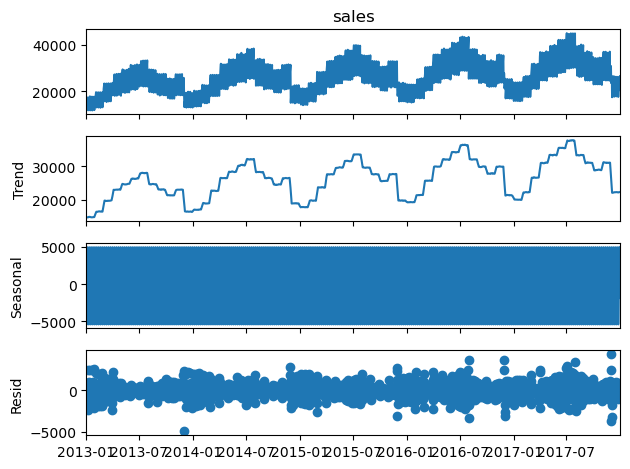

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df["sales"], model="additive", period=7)
decomp.plot();


In [11]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df["sales"])
print("ADF p-value:", adf[1])


ADF p-value: 0.029638649268843673


In [12]:
train = df.iloc[:-30]
test = df.iloc[-30:]


In [14]:
!pip install prophet


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.1 MB 11.9 MB/s eta 0:00:01
   ------------- -------------------------- 4.2/12.1 MB 11.2 MB/s eta 0:00:01
   -------------------- ------------------- 6.3/12.1 MB 10.8 MB/s eta 0:00:01
   ---------------------- ----------------- 6.8/12.1 MB 9.6 MB/s eta 0:00:01
   ----------------------- ---------------- 7.1/12.1 MB 8.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.6/12.1 MB 6.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.9/12.1 MB 6.0 MB/s eta 0:00:01
   ---------------------------- ----------- 8.7/12.1 MB 5.3 MB/s eta 0:00:01
   ------------------------------ --------- 9.2/12.1 MB 5.1 MB/s eta 0:00:01
   -------------------------------- ------- 10.0/12.1 MB 4.9 MB/s eta 0:00:01
   ----------------------------------- ---- 10.7/12.1 MB 4.8 MB/s eta 0:00:01
   -------------------------------------- - 11.5/12.1 MB 4.8 MB/s eta 0:00:01


In [15]:
from prophet import Prophet

prophet_df = train.reset_index()
prophet_df.columns = ["ds", "y"]

prophet_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1
)

prophet_model.fit(prophet_df)


10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing


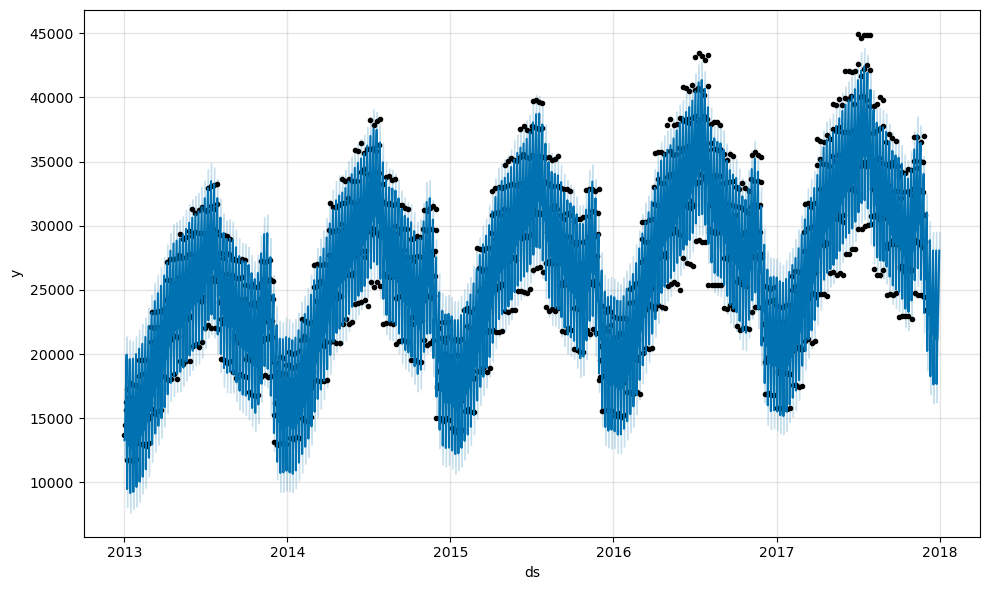

In [16]:
future = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future)

prophet_model.plot(forecast_prophet);


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(
    train["sales"],
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)

sarima_fit = sarima.fit()
sarima_forecast = sarima_fit.get_forecast(steps=30)
sarima_pred = sarima_forecast.predicted_mean


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prophet predictions (last 30 days)
prophet_pred = forecast_prophet.iloc[-30:]["yhat"]

mae_prophet = mean_absolute_error(test["sales"], prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(test["sales"], prophet_pred))

# SARIMA predictions
mae_sarima = mean_absolute_error(test["sales"], sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(test["sales"], sarima_pred))


In [20]:
print("MODEL EVALUATION RESULTS\n")

print("Prophet Model")
print(f"MAE  : {mae_prophet:.2f}")
print(f"RMSE : {rmse_prophet:.2f}\n")

print("SARIMA Model")
print(f"MAE  : {mae_sarima:.2f}")
print(f"RMSE : {rmse_sarima:.2f}")


MODEL EVALUATION RESULTS

Prophet Model
MAE  : 1636.74
RMSE : 2025.78

SARIMA Model
MAE  : 1657.92
RMSE : 1959.24


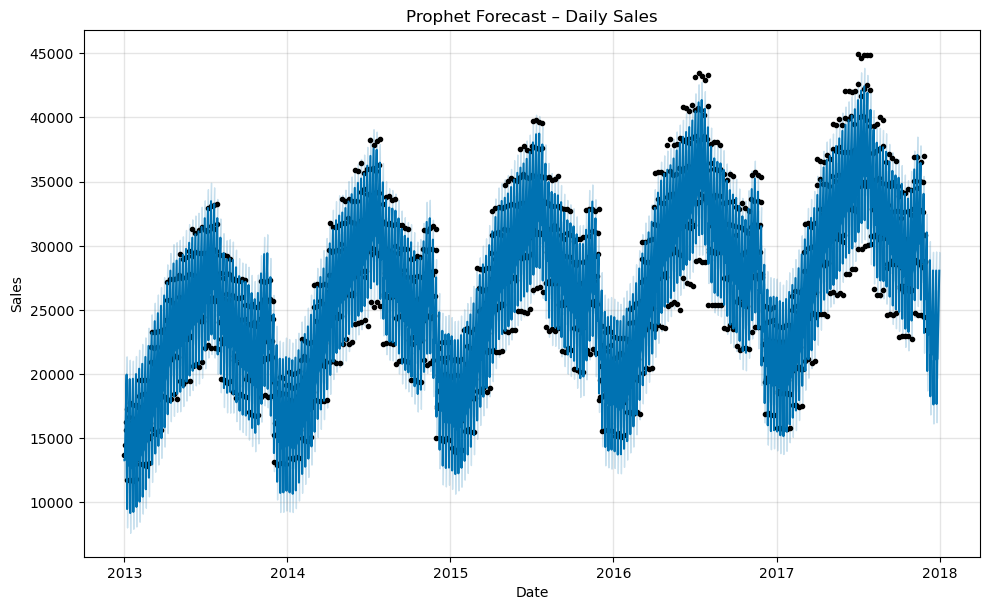

In [21]:
import matplotlib.pyplot as plt

fig1 = prophet_model.plot(forecast_prophet)
plt.title("Prophet Forecast – Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.savefig("prophet_forecast.png", dpi=300, bbox_inches="tight")
plt.show()


NameError: name 'sarima_ci' is not defined

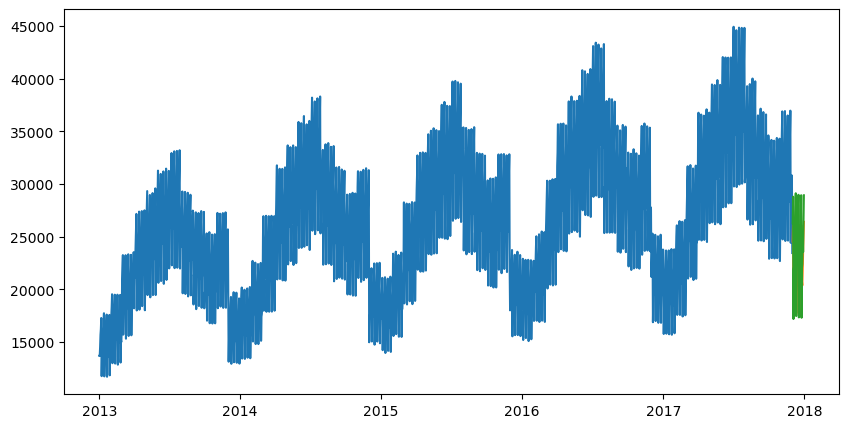

In [22]:
plt.figure(figsize=(10,5))

plt.plot(train.index, train["sales"], label="Train")
plt.plot(test.index, test["sales"], label="Test")
plt.plot(test.index, sarima_pred, label="SARIMA Forecast")

plt.fill_between(
    test.index,
    sarima_ci.iloc[:, 0],
    sarima_ci.iloc[:, 1],
    alpha=0.2
)

plt.title("SARIMA Forecast – Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.savefig("sarima_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
